In [1]:
from scipy.optimize import golden
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control = composite_sys(squid,cavity)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise = (H_per - H) / self.epsilon
        
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        
        self.noise = self.truncate_matrix(self.noise, self.trunc)
        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 6.159 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control

    def H_approximation(self,  omega,):
        self.get_H()
        s = self.annihilation(self.sdim)
        sd = self.creation(self.sdim)
        c = self.annihilation(self.cdim)
        cd = self.creation(self.cdim)
        Is = np.eye(self.sdim)
        Ic = np.eye(self.cdim)
        H = (self.omega_s - omega)* np.kron(sd@s,Ic) + self.anh/2 *np.kron(sd@sd@s@s,Ic) + self.omega_c*np.kron(Is,cd@c) 
        +self.chi*np.kron(sd@s,cd@c) 
        H = self.truncate_matrix(H, self.trunc)
        Hc =  1/2/2/self.phi_zpf*(np.kron(s+sd,Ic))
        Hc = self.truncate_matrix(Hc, self.trunc)
        return H,Hc

In [250]:
def gaussian_ramp(initial_time, t0, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0

    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        t_mid = initial_time / 2  # Middle point of the time range
        t_rise = t0  # Time for rising edge
        t_fall = initial_time - t0  # Time for falling edge
        
        if t <= t_rise:
            # Gaussian rise centered at t_rise
            return amplitude * np.exp(-((t - t_rise)**2) / (2 * sigma**2)) - amplitude * np.exp(-((0 - t_rise)**2) / (2 * sigma**2))
        elif t >= t_fall:
            # Gaussian fall centered at t_fall
            return amplitude * np.exp(-((t - t_fall)**2) / (2 * sigma**2)) - amplitude * np.exp(-((initial_time - t_fall)**2) / (2 * sigma**2))
        else:
            # Constant amplitude in the middle region
            return amplitude - amplitude * np.exp(-((0 - t_rise)**2) / (2 * sigma**2))


    return time_dependent_function


In [251]:
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
trunc = [5,3]
sc = Hamiltonian(phi_ex, Ej, Ec, trunc)
# A = 10e-3*2*np.pi
# optimal_omegad = sc.optimal_omegad(A)[0]

In [252]:
optimal_omegad/2/np.pi

6.1871046633941456

In [253]:
total_dim = trunc[-2]*trunc[-1]

In [254]:
tlist = np.linspace(0, 500, 100000)  # Cover ten periods
func = gaussian_ramp(500,100, A)

In [255]:
func(500)

0.0

In [256]:
f

NameError: name 'f' is not defined

In [257]:
func(0)

0.0

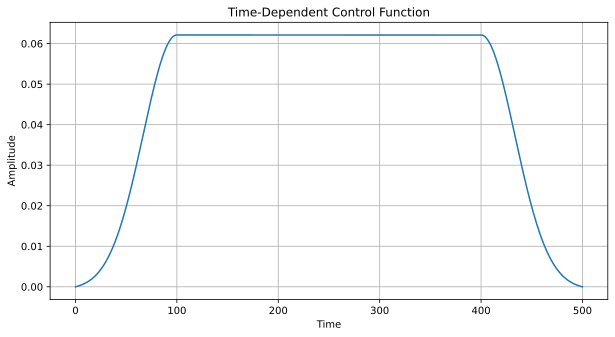

In [258]:
# Plot the time-dependent function
plt.figure(figsize=(10, 5))
plt.plot(tlist, [func(t) for t in tlist])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time-Dependent Control Function')
plt.grid(True)
plt.show()


In [260]:
H0

Quantum object: dims=[[15], [15]], shape=(15, 15), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.         32.76595474  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         65.53190947  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.         -0.17602835  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.         32.58992638  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.   

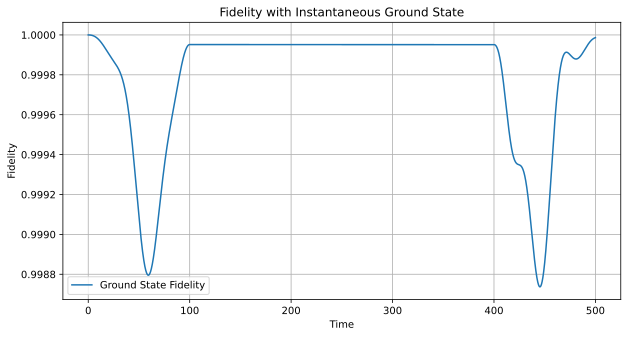

In [261]:
psi0 = qt.basis(total_dim, 1)  # Use the dimension from the Hamiltonian object
H0, Hc = sc.H_approximation(optimal_omegad)  # Use the Hamiltonians from the sc object
H0 = qt.Qobj(H0)
Hc = qt.Qobj(Hc)

H = [H0, [Hc, lambda t, args: func(t)]]
options = {"nsteps": 100000, "rtol": 1e-10, "atol": 1e-10}
result = qt.sesolve(H, psi0, tlist, options=options)

# Calculate instantaneous eigenstates for each time point
fidelities = []
evecs_list = []  # Store all eigenvectors
for i in range(len(tlist)):
    # Construct instantaneous Hamiltonian
    H_t = H0 + Hc * func(tlist[i])
    # Get eigenvalues and eigenvectors
    H_t = H_t.full()
    evals, evecs = np.linalg.eig(H_t)
    evals,evecs = sort_eigenpairs(evals,evecs)
    evecs_list.append(evecs)  # Store eigenvectors for this time point
    # Ground state is the eigenstate with lowest energy
    ground_state = qt.Qobj(evecs[:,1])
    # Calculate fidelity between evolved state and ground state
    fidelity = abs((ground_state.dag() * result.states[i]))**2
    fidelities.append(fidelity)

# Plot fidelities vs time
plt.figure(figsize=(10, 5))
plt.plot(tlist, fidelities, label='Ground State Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity with Instantaneous Ground State')
plt.legend()
plt.grid(True)
plt.show()


In [263]:
fidelities[-1]

0.9999863729363562

In [106]:
evecs_list[-1]

array([Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
       Qobj data =
       [[-0.23331947]
        [ 0.97240014]]                                                       ,
       Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
       Qobj data =
       [[-0.97240014]
        [-0.23331947]]                                                       ],
      dtype=object)

In [107]:
H_t = H0 + Hc * func(tlist[i])
    # Get eigenvalues and eigenvectors
evals, evecs = H_t.eigenstates()
H_t = H_t.full()

evals, evecs = np.linalg.eig(H_t)
evals,evecs = sort_eigenpairs(evals,evecs)

In [108]:
evecs

array([[ 0.97240014+0.j, -0.23331947+0.j],
       [ 0.23331947-0.j,  0.97240014+0.j]])